In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import yaml
from pathlib import Path

In [31]:
def read_txt(label_dir):
    res = pd.read_csv(label_dir, 
                      sep = ' ',
                      names = ['label', 'x_center', 'y_center', 'width', 'height']).values
    return res

In [53]:
def read_img_labels(img_dir):
    img_dir = Path(img_dir)
    
    file_name = img_dir.stem
    sample_folder = img_dir.parent.name
    root_dir = img_dir.parent.parent.parent
    
    file_txt = f'{file_name}.txt'
    label_dir = root_dir / 'labels' / sample_folder / file_txt
    
    if label_dir.exists():
        return read_txt(str(label_dir))
    else:
        return None

In [55]:
def read_dataset(yaml_dir, data_dir):
    data_dir = Path(data_dir)
    
    yaml_dict = yaml.safe_load(Path(yaml_dir).read_text())
    img_list = [str(p) for p in data_dir.rglob('images\\*\\*.jpg')]
    
    data = pd.DataFrame(columns = ['dir'], data = img_list)
    
    data['size'] = data['dir'].apply(lambda x: Image.open(x).size)
    data['img_abs_width'] = data['size'].apply(lambda x: x[0])
    data['img_abs_height'] = data['size'].apply(lambda x: x[1])
    data['annotations'] = data['dir'].apply(lambda x: read_img_labels(x))
    
    data = data[~data['annotations'].isna()]
    data = data.explode('annotations')
    data = data.reset_index(drop=True)

    data['class_id'] = data['annotations'].apply(lambda x: x[0])
    data['x_center_rel'] = data['annotations'].apply(lambda x: x[1])
    data['y_center_rel'] = data['annotations'].apply(lambda x: x[2])
    data['width_rel'] = data['annotations'].apply(lambda x: x[3])
    data['height_rel'] = data['annotations'].apply(lambda x: x[4])
    data['class_str'] = data['class_id'].apply(lambda x: yaml_dict['names'][int(x)].lower())
    data['x_center_abs'] = data.apply(lambda x: x['x_center_rel'] * x['size'][0], axis=1)
    data['y_center_abs'] = data.apply(lambda x: x['y_center_rel'] * x['size'][1], axis=1)
    data['width_abs'] = data.apply(lambda x: x['width_rel'] * x['size'][0], axis=1)
    data['height_abs'] = data.apply(lambda x: x['height_rel'] * x['size'][1], axis=1)
    data['aspect_ratio'] = data.apply(lambda x: x['width_rel'] / x['height_rel'], axis=1)
    data['split'] = data.apply(lambda x: Path(x['dir']).parent.name, axis=1)
    
    return data

In [57]:
data_path = r'D:\UAV_obj_det\datasets'
yaml_path = r'D:\UAV_obj_det\datasets\dataset.yaml'

In [83]:
data = read_dataset(yaml_path, data_path)

In [84]:
data.head()

,dir,size,img_abs_width,img_abs_height,annotations,class_id,x_center_rel,y_center_rel,width_rel,height_rel,class_str,x_center_abs,y_center_abs,width_abs,height_abs,aspect_ratio,split
0,D:\UAV_obj_det\datasets\images\test\0_100_30_0...,"(640, 512)",640,512,"[1.0, 0.3171875, 0.2451171875, 0.053125, 0.068...",1.0,0.317188,0.245117,0.053125,0.068359,car,203.0,125.5,34.0,35.0,0.777143,test
1,D:\UAV_obj_det\datasets\images\test\0_100_30_0...,"(640, 512)",640,512,"[1.0, 0.56015625, 0.201171875, 0.0578125, 0.07...",1.0,0.560156,0.201172,0.057813,0.074219,car,358.5,103.0,37.0,38.0,0.778947,test
2,D:\UAV_obj_det\datasets\images\test\0_100_30_0...,"(640, 512)",640,512,"[1.0, 0.1890625, 0.2880859375, 0.046875, 0.052...",1.0,0.189062,0.288086,0.046875,0.052734,car,121.0,147.5,30.0,27.0,0.888889,test
3,D:\UAV_obj_det\datasets\images\test\0_100_30_0...,"(640, 512)",640,512,"[1.0, 0.5421875, 0.08203125, 0.03125, 0.04296875]",1.0,0.542188,0.082031,0.031250,0.042969,car,347.0,42.0,20.0,22.0,0.727273,test
4,D:\UAV_obj_det\datasets\images\test\0_100_30_0...,"(640, 512)",640,512,"[1.0, 0.65546875, 0.1796875, 0.0453125, 0.0546...",1.0,0.655469,0.179688,0.045312,0.054688,car,419.5,92.0,29.0,28.0,0.828571,test


In [91]:
data.describe()

,img_abs_width,img_abs_height,class_id,x_center_rel,y_center_rel,width_rel,height_rel,x_center_abs,y_center_abs,width_abs,height_abs,aspect_ratio
count,24899.0,24899.0,24899.000000,24899.000000,24899.000000,24899.000000,24899.000000,24899.000000,24899.000000,24899.000000,24899.000000,24899.000000
mean,640.0,512.0,0.735250,0.506489,0.451331,0.044899,0.062266,324.152817,231.081449,28.735451,31.880316,0.732736
std,0.0,0.0,0.837672,0.253180,0.262989,0.037747,0.043709,162.035053,134.650350,24.158045,22.379091,0.413960
min,640.0,512.0,0.000000,0.002344,0.003906,0.004687,0.007812,1.500000,2.000000,3.000000,4.000000,0.115789
25%,640.0,512.0,0.000000,0.314063,0.232422,0.017188,0.035156,201.000000,119.000000,11.000000,18.000000,0.444444
50%,640.0,512.0,1.000000,0.505469,0.439453,0.029687,0.046875,323.500000,225.000000,19.000000,24.000000,0.610909
75%,640.0,512.0,1.000000,0.703125,0.655273,0.059375,0.070312,450.000000,335.500000,38.000000,36.000000,0.880000
max,640.0,512.0,4.000000,0.996875,0.996094,0.473438,0.361328,638.000000,510.000000,303.000000,185.000000,4.888889


In [99]:
pd.DataFrame(data = {
    'n_images': data.groupby('split').dir.unique().apply(len).to_dict(),
    'n_labels': data.split.value_counts().to_dict()
})

,n_images,n_labels
test,571,4811
train,2008,17628
val,287,2460


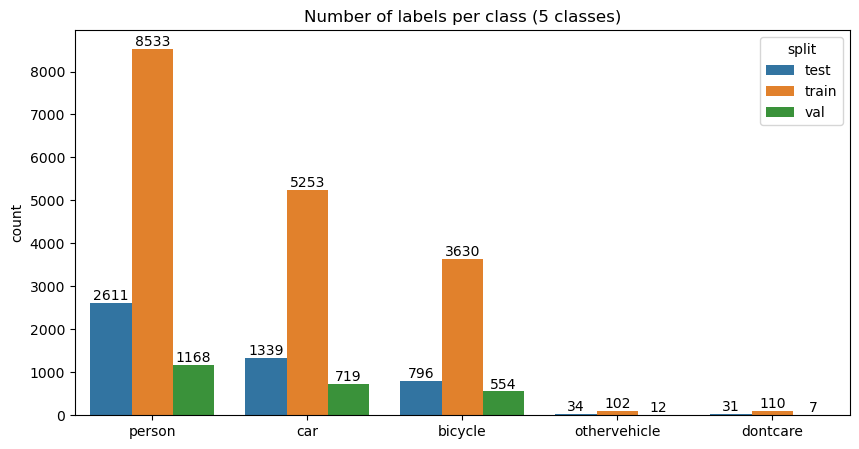

In [214]:
fig, ax = plt.subplots(figsize=(10, 5))
order = data['class_str'].value_counts().sort_values(ascending=False).index
sns.countplot(x='class_str', hue='split', data=data, ax=ax, order=order)
plt.xlabel('')
for i in ax.containers:
    ax.bar_label(i)
plt.title(f"Number of labels per class ({len(df.class_str.value_counts())} classes)")
plt.show()

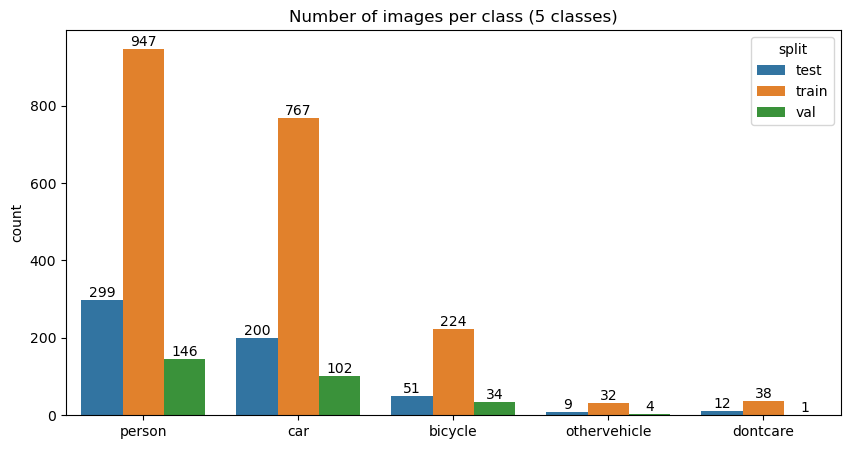

In [206]:
idx2url = data['dir'].to_dict()
url2idx = {v: k for (k, v) in idx2url.items()}
ddf = data.loc[[v for k, v in url2idx.items()]]

fig, ax = plt.subplots(figsize=(10, 5))
order = df['class_str'].value_counts().sort_values(ascending=False).index
sns.countplot(x='class_str', hue='split', data=ddf, ax=ax, order=order)
plt.xlabel('')
for i in ax.containers:
    ax.bar_label(i)
plt.title(f"Number of images per class ({len(df.class_str.value_counts())} classes)")
plt.show()

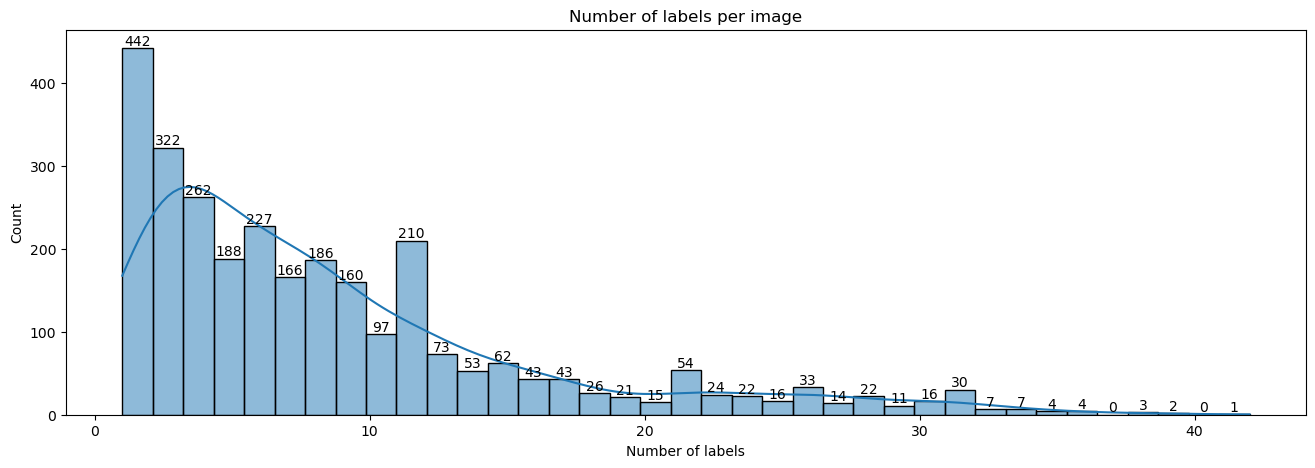

In [210]:
fig, ax = plt.subplots(figsize=(16, 5))

ddf = df[['dir', 'split']].pivot_table(index='dir', columns=['split'], aggfunc=lambda l: int(len(l))).reset_index().melt('dir')
ddf = ddf[~ddf['value'].isna()]
sns.histplot(data=ddf, x='value', kde = True)

plt.xlabel('Number of labels')
plt.ylabel('Count')
for i in ax.containers:
    ax.bar_label(i)
    
plt.xticks(rotation=0)
plt.title('Number of labels per image')
plt.show()